### Bevægelsesligninger

Den resulterende kraft på et objekt udsat for luftmodstand i et skråt kast er

$$\mathbf{F_{objekt}} = m \mathbf{g} - \alpha | \mathbf{v} |^2 \cdot  \hat{\mathbf{v}} = m \vec{g} - \alpha | \mathbf{v} | \cdot  \mathbf{v}$$

Vi ser at kraftligningerne langs x- og y-aksen er

$$\Sigma F_x = - \alpha | \mathbf{v} | \cdot v_x = m a_x$$

$$\Sigma F_y = - m \mathbf{g} - \alpha | \mathbf{v} | \cdot  v_y = m a_y$$

Accelerationen af objektet er givet ved

$$
\mathbf{a} = \frac{d\mathbf{v}}{dt} =
\begin{bmatrix}
a_x \\
a_y \\
\end{bmatrix}
=
\begin{bmatrix}
- \frac{\alpha}{m} | \mathbf{v} | \cdot  v_x \\
- g - \frac{\alpha}{m} | \mathbf{v} | \cdot  v_y \\
\end{bmatrix}
$$



$ \mathbf{a} $ ændrer sig hele tiden, men for tilpas korte tidsintervaller $\Delta t$ er den tilnærmelsesvis konstant og svarer til gennemsnitshastigheden over tidsintervallet. Dvs. at vi kan bruge ligningen

$$ \mathbf{a} = \frac{\Delta \mathbf{v}}{\Delta t} $$

$$ \rightarrow  \Delta \mathbf{v} = \mathbf{a} \cdot \Delta t $$


Med hensyn til ændringen i objektets position ved vi at gennemsnitshastigheden over tidsintervallet er givet ved

$$ \frac{(\mathbf{v} + (\mathbf{v} + \Delta \mathbf{v}))}{2} = \\
(\mathbf{v} + \frac{\Delta \mathbf{v}}{2})$$

Eftersom $\mathbf{v}$ er hastigheden i starten af tidsintervallet og $\mathbf{v} + \Delta \mathbf{v}$ er hastigheden i slutningen af tidsintervallet.

Altså må ændringen i positionen være givet ved

$$\Delta \mathbf{s} = (\mathbf{v} + \frac{\Delta \mathbf{v}}{2}) \cdot \Delta t $$

$$ = \mathbf{v} \cdot \Delta t + \frac{\Delta \mathbf{v} \cdot \Delta t}{2} $$

$$ = \mathbf{v} \cdot \Delta t + \frac{\mathbf{a} \cdot {\Delta t}^2}{2} $$

### Implementering

Nu er vi klar til at lave simulationen. Vi starter med nogle begyndelsesbetingelser og laver en løkke der opdaterer objektets position og hastighed løbende indtil objektet rammer jorden.

In [28]:
import matplotlib.pyplot as plt
import numpy as np

def len(vector):
    return np.linalg.norm(vector)

# Tager s_0 som et array eller en tuple
def simulate_throw(alpha, g, m, v_0, s_0, theta_0, Delta_t):
    # Startbetingelser
    t = 0
    s = np.array(s_0)
    v = v_0 * np.array([np.cos(theta_0), np.sin(theta_0)])
    
    a = np.array([0,0])

    # For at gemme objektets bevægelse i løbet af simulationen
    x_arr = []
    y_arr = []
    t_arr = []

    # Kør simulationen indtil objektet rammer jorden
    while (s[1] > 0):
        # Udregn t
        t += Delta_t

        # Udregn accelerationen
        a[0] = -(alpha/m)*len(v)*v[0]
        a[1] = -g -(alpha/m)*len(v)*v[1]

        # Udregn hastighedsændring
        v = v + a * Delta_t
        
        # Udregn positionsændring
        s = s + v * Delta_t + (a * Delta_t**2)/2

        # Gem position
        x_arr.append(s[0])
        y_arr.append(s[1])
        t_arr.append(t)

    # Skudlængde
    l = x_arr[-1]

    # Plot objektets bane
    plt.figure(1)
    plt.grid()
    plt.xlabel("x")
    plt.ylabel("y")
    plt.plot(x_arr, y_arr)
    plt.xlim(0, max(x_arr) + 0.5)
    plt.ylim(0, max(y_arr) + 0.5)
    plt.show()

    # Print og returner skudlængden
    print("Skudlængde: {:.1f}".format(l))

    return l



Vi kører simulationen for $\theta = \frac{\pi}{4} $

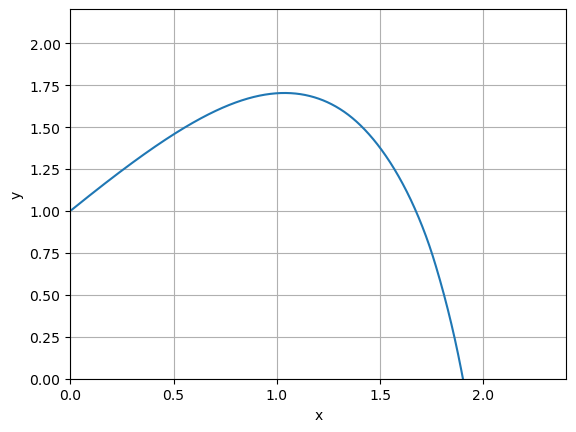

Skudlængde: 1.9


In [30]:
# Vi kalder funktionen med værdierne vi får givet i opgaven og theta = pi/4
simulate_throw(alpha=0.1, g=10, m=0.1, v_0=10, s_0=[0, 1], theta_0=(np.pi/4), Delta_t=0.001)


Nu er tiden kommet til at finde vinklen der fører til den størst mulige skudlængde. Vi får at vide at vi skal teste mindst 50 forskellige vinkler, men det er nok bedst at teste lidt flere end det. Vi starter med at teste 50 jævnt fordelte vinkler.

In [ ]:
# Tjek 50 vinkler

# Find vinklen hvor l er størst

# Tjek 50 vinkler mellem de to vinkler omkring den fundne

# 50 jævnt fordelte vinkler
angles = np.arange(0, np.pi/2)
# Gemmer vinkler og tilhørende skudlængder
res = []

for i in len(angles):
    res.append(angles[i], )


